<a href="https://colab.research.google.com/github/Amarantine-xiv/Another-FF14-Combat-Sim/blob/main/CombatSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023 Amarantine Falena

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [92]:
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
import time
import copy

from enum import Enum

In [93]:
#@title Define stat tiers and class modifiers ###
def get_dh_stat(dh_stat):
  return np.floor(550*(dh_stat-400)/1900)/1000

def get_dot_multiplier(speed_stat):
  return (1000+np.floor(130*(speed_stat-400)/1900))/1000  
  
def get_gcd_time(speed_stat, base_gcd_time):
  return (np.floor((1000*base_gcd_time)*(1000+np.ceil(130*(400-speed_stat)/1900))/10000)/100)

def get_det_bonus(det_stat):
  return (1000+np.floor(140*(det_stat-390)/1900))/1000

def get_crit_stats(crit_stat):
  crit_rate = (np.floor(200*(crit_stat-400)/1900)+50)/1000
  crit_bonus = (np.floor(200*(crit_stat-400)/1900)+400)/1000
  return crit_rate, crit_bonus

# from Hint's repo, https://github.com/hintxiv/reassemble
def fAP(main_stat, isTank= False):
  if isTank:
    return np.floor(156*(main_stat-390)/390) + 100
  return np.floor(195*(main_stat-390)/390) + 100

def fTnc(tenacity):
  return (1000+np.floor(100*(tenacity-400)/1900))/1000

def fAuto(wd, weapon_delay, job_mod):
  return np.floor(np.floor(390 * job_mod / 1000 + wd) * (weapon_delay / 3))

# from Hint's repo, https://github.com/hintxiv/reassemble
def fDet(det_stat):
  return np.floor(140*(det_stat-390)/1900) + 1000

# for taking into account bonuses from guranteed dhs.
def fDetDH(det_stat, dh_stat):
  return np.floor(140*(det_stat-390)/1900) + np.floor(140*(dh_stat-390)/1900) + 1000

# from Hint's repo, https://github.com/hintxiv/reassemble
def fWD(wd, job_mod):
  return np.floor(390*job_mod/1000 + wd)

# from Hint's repo, https://github.com/hintxiv/reassemble
def fSpd(speed_stat):
  return np.floor(130 * (speed_stat - 400) / 1900 + 1000)

# See https://www.akhmorning.com/allagan-studies/modifiers/ . Each class' class num is its main attribute #.
JOB_MODS = {'SCH': 115, 'WAR': 105}

def isCaster(job_class):
  return job_class in ['RDM', 'BLM', 'BLU', 'SMN']

def isHealer(job_class):
  return job_class in ['SCH', 'WHM', 'AST', 'SGE']

def isTank(job_class):
  return job_class in ['GNB', 'WAR', 'PLD', 'DRK']

def compute_trait_dmg_add(job_class):
  if job_class == 'SCH':
    return 0.30
  elif job_class == 'WAR':
    return 0
  else:
    return 0

class Stats():
  def __init__(self, wd, weapon_delay, main_stat, det_stat, crit_stat, dh_stat, speed_stat, job_class, healer_or_caster_strength = None, tenacity=None, num_roles_in_party=5):
    self.wd = wd
    self.weapon_delay = weapon_delay
    self.main_stat = main_stat
    self.det_stat = det_stat
    self.dh_stat = dh_stat
    self.crit_stat = crit_stat    
    self.speed_stat = speed_stat
    self.job_class = job_class
    self.job_mod = JOB_MODS[job_class]
    self.tenacity = tenacity
    self.trait_dmg_add = compute_trait_dmg_add(job_class)
    self.num_roles_in_party = num_roles_in_party
    # only for healers/caster does strength matter. We note in here so it's not as confusing if we're dealing with a tank. Tanks should just use main_stat to indicate their strength.
    self.healer_or_caster_strength = healer_or_caster_strength    




In [94]:
#@title StatusEffects, ProcessedStats
class StatusEffects():
  def __init__(self):    
    self.damage_mult = 1
    self.crit_rate_add = 0    
    self.dh_rate_add = 0
    self.main_stat_add = 0
    self.active = {}

  def __str__(self):
    res = 'damage_mult: ' + str(self.damage_mult) + '\n'
    res += 'crit_rate_add: ' + str(self.crit_rate_add) + '\n'
    res += 'dh_rate_add: ' + str(self.dh_rate_add) + '\n'
    res += 'main_stat_add: ' + str(self.main_stat_add) + '\n'
    return res

class ProcessedStats():
  def __init__(self, stats):
    (crit_rate, crit_bonus) = get_crit_stats(stats.crit_stat)
    self.stats = stats
    self.crit_rate = crit_rate
    self.crit_bonus =  crit_bonus
    self.det_bonus = get_det_bonus(stats.det_stat)
    self.dh_rate = get_dh_stat(stats.dh_stat)    
    self.dot_multiplier = get_dot_multiplier(stats.speed_stat)

  def  __str__(self):
    res = 'Crit rate:' + str(self.crit_rate) + '\n'
    res += 'Crit bonus:' + str(self.crit_bonus) + '\n'
    res += '\nDet bonus:' + str(self.det_bonus) + '\n'
    res += '\nDH Rate:' + str(self.dh_rate)
    res += '\nDot Multiplier:' + str(self.dot_multiplier)    
    return res  

In [95]:
#@title SkillDamageSpec, SkillStatusEffectSpec, Skill, ForcedCritOrDH

class DamageClass(Enum):
    UNKNOWN = 0
    DIRECT = 1
    DOT = 2
    AUTO = 3

class ForcedCritOrDH(Enum):
  UNKNOWN = 0
  DEFAULT = 1
  FORCE_NO = 2
  FORCE_YES = 3
  FORCE_YES_WITH_NO_DMG_BONUS = 4

class SkillDamageSpec():
  def __init__(self, potency= None, damage_class = DamageClass.DIRECT, guaranteed_crit= None, guaranteed_dh= None, use_trait_buff= True):
    self.potency = potency
    self.damage_class = damage_class
    self.guaranteed_crit = guaranteed_crit
    self.guaranteed_dh = guaranteed_dh
    self.use_trait_buff = use_trait_buff

  def  __str__(self):
    res = 'potency:' + str(self.potency) + '\n'
    res += 'damage class:' + str(self.damage_class) + '\n'
    return res 

class SkillStatusEffectSpec():
  def __init__(self, duration, max_duration= None, crit_rate_add= 0, dh_rate_add= 0, main_stat_add= 0, damage_mult = 1):
    self.duration = duration
    if max_duration is None:
      self.max_duration = duration
    else:
      self.max_duration = max_duration
    self.main_stat_add = main_stat_add
    self.crit_rate_add = crit_rate_add
    self.dh_rate_add = dh_rate_add
    self.damage_mult = damage_mult    

  def  __str__(self):
    res = 'main_stat_add:' + str(self.main_stat_add) + '\n'
    res += 'crit_rate_add:' + str(self.crit_rate_add) + '\n'
    res += 'dh_rate_add:' + str(self.dh_rate_add) + '\n'
    res += 'damage_mult:' + str(self.damage_mult) + '\n'
    res += 'duration:' + str(self.duration) + '\n'
    res += 'max_duration:' + str(self.max_duration) + '\n'
    return res 

class Skill():
  # Consider making this class immutable
  def __init__(self, name, damage_spec = None, buff_spec = None, debuff_spec = None, follow_up_skills=None, has_snapshot_buffs = None, has_snapshot_debuffs = None):
    #follow _up skills is list of tuples of the form (delay, Skill()) to add to the queue when this skill triggers
    self.name = name
    self.damage_spec = damage_spec
    self.buff_spec = buff_spec
    self.debuff_spec = debuff_spec
    self.follow_up_skills = follow_up_skills
    self.has_snapshot_buffs = has_snapshot_buffs
    self.has_snapshot_debuffs = has_snapshot_debuffs

  def _compute_direct_damage(self, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    stats = processed_stats.stats
    is_tank = isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    # from HINT
    potency = self.damage_spec.potency
    ap = fAP(main_stat, is_tank)
    wd = fWD(stats.wd, stats.job_mod)
    det = fDet(stats.det_stat)
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      det_dh = fDetDH(stats.det_stat, stats.dh_stat)
    else:
      det_dh = det

    # TODO: move to readme or somewhere better than this.
    # 1) main stat changed by pots/party buffs (# of roles)
    # 2) potency and fAP are taken into account
    # 3) det (and potentially dh if autocrit) is taken into account
    # 4) tnc is taken into account, if applicable (tanks)
    # 5) sps/sks is taken into account, if applicable (eg, dots)
    # 6) weapon damage and weapon delay are taken account, if applicable
    # 7) apply the +1 for dots
    # 8) apply guaranteed crit bonus using crit rate up, if applicable
    # 9) apply guaranteed direct hit bonus dh up, if applicable
    # 10) apply +-5% damage variance (on ALL sources of damage, direct, auto, dot)
    # 11) crit/direct hit multipliers are taken into account, if applicable. NO FLOORING IS DONE HERE (but i can if you think i should)
    # 12) traits are taken into account, if applicable
    # 13) each straight up damage buff/enemy increased damage taken is taken into account multiplicatively. NO FLOORING IS DONE BETWEEN APPLYING BUFFS

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*fTnc(stats.tenacity))    
    base_damage = np.floor(base_damage*wd)       

    # take into account crit rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular crit roll, but we do it here for simplicity.
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES:
      crit_rate_bonus = buffs.crit_rate_add + debuffs.crit_rate_add
      base_damage += np.floor(base_damage*crit_rate_bonus*processed_stats.crit_bonus)

    # take into account dh rate ups.
    # according to latest damage formulas, we should account for this AFTER
    # the regular dh roll, but we do it here for simplicity.
    if guaranteed_dh is ForcedCritOrDH.FORCE_YES:
      dh_rate_bonus = buffs.dh_rate_add + debuffs.dh_rate_add
      base_damage += np.floor(base_damage*dh_rate_bonus*0.25)

    return base_damage

  def _compute_dot_damage(self, processed_stats, buffs, debuffs):
    # Q: what is the dot damage formula for tanks with tenacity?

    stats = processed_stats.stats
    is_tank = isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    potency = self.damage_spec.potency
    spd = fSpd(stats.speed_stat)
    ap = fAP(main_stat, is_tank)
    det = fDet(stats.det_stat)
    wd = fWD(stats.wd, stats.job_mod)

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*fTnc(stats.tenacity))
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*wd)
    base_damage = base_damage + 1
    return base_damage

  def _compute_auto_damage(self, processed_stats, buffs, debuffs):
    stats = processed_stats.stats
    if (isHealer(stats.job_class) or isCaster(stats.job_class)):
      # for healers/casters, the statu used to compute autos is strength, not main stat. So use that and pots and party bonus doesn't affect it
      if stats.healer_or_caster_strength is None:
        raise RuntimeError('Cannot compute auto attack damage for healer/caster unless healer_or_caster_strength stat is specified.') 
      auto_main_stat = stats.healer_or_caster_strength      
    else:
      # for non-healers/casters, the stat used to compute autos is our main stat, and we get all the buffs/bonuses on it
      auto_main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
      auto_main_stat = np.floor(auto_main_stat*(1+0.01*stats.num_roles_in_party))
    
    is_tank = isTank(stats.job_class)
    potency = self.damage_spec.potency
    spd = fSpd(stats.speed_stat)
    ap = fAP(auto_main_stat, is_tank)
    det = fDet(stats.det_stat)
    auto = fAuto(stats.wd, stats.weapon_delay, stats.job_mod)

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*fTnc(stats.tenacity))
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*auto)
    return base_damage

  def get_base_damage(self, processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh):
    if self.damage_spec is None:
      return None    
    
    if (self.damage_spec.damage_class == DamageClass.DIRECT):
        base_damage = self._compute_direct_damage(processed_stats, buffs, debuffs, guaranteed_crit, guaranteed_dh)
    elif (self.damage_spec.damage_class == DamageClass.DOT):
        base_damage = self._compute_dot_damage(processed_stats, buffs, debuffs)
    elif (self.damage_spec.damage_class == DamageClass.AUTO):
        base_damage = self._compute_auto_damage(processed_stats, buffs, debuffs)
    else:
        base_damage = None
    return base_damage

  def __gt__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    return self.name > other.name
  def __lt__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    return self.name < other.name
  def __eq__(self, other):
    print('Warning: invoking comparison between skills:' + self.name + ' and ' + other.name + '. This is likely due to skills triggering at the same time. Comparisons are random.')
    self.name == other.name

  def __hash__(self):
    return hash(self.name)

  def  __str__(self):
    res = 'Name:' + str(self.name) + '\n'
    if self.damage_spec is None:
      res += '---No damage spec---\n'
    else:
      res += str(self.damage_spec)
    if self.buff_spec is None:
      res += '---No skill buff spec---\n'
    else:
      res += str(self.buff_spec)
    res += 'HasSnapshotBuffs:' + str(self.has_snapshot_buffs)  + '\n'
    res += 'HasSnapshotDebuffs:' + str(self.has_snapshot_buffs)  + '\n'
    if self.follow_up_skills is not None:
      for i in range(0, len(self.follow_up_skills)):
        res += "Follow up skill " + str(i) + ". Delay: " + str(self.follow_up_skills[i][0]) + '\n'
        res += str(self.follow_up_skills[i][1]) + '\n'
    return res  

In [96]:
#@title All skill specifications

AllSkills = {}
AllSkills['General'] = {}
AllSkills['General']['Pot'] = Skill('Pot', buff_spec = SkillStatusEffectSpec(duration= 30, main_stat_add=223))
AllSkills['SCH'] = {}
AllSkills['SCH']['_Biolysis_dot'] = Skill('_Biolysis_tick', damage_spec=SkillDamageSpec(potency=70, damage_class=DamageClass.DOT))
AllSkills['SCH']['Auto'] = Skill('Auto', damage_spec=SkillDamageSpec(potency=80, damage_class=DamageClass.AUTO, use_trait_buff= False))
AllSkills['SCH']['Broil'] = Skill('Broil', damage_spec=SkillDamageSpec(potency=295))
AllSkills['SCH']['EnergyDrain'] = Skill('EnergyDrain', damage_spec=SkillDamageSpec(potency=100))
AllSkills['SCH']['ArtOfWar'] = Skill('ArtOfWar', damage_spec=SkillDamageSpec(potency=165))
AllSkills['SCH']['ChainStrategem'] = Skill('ChainStrategem', debuff_spec= SkillStatusEffectSpec(duration=15, crit_rate_add=0.10))
AllSkills['SCH']['Biolysis'] = Skill('Biolysis', has_snapshot_buffs = True, has_snapshot_debuffs = True, follow_up_skills=[(t, AllSkills['SCH']['_Biolysis_dot']) for t in range(0,30,3)])

AllSkills['WAR'] = {}
AllSkills['WAR']['Auto'] = Skill('Auto', damage_spec=SkillDamageSpec(potency=90, damage_class=DamageClass.AUTO, use_trait_buff= False))
AllSkills['WAR']['HeavySwing'] = Skill('HeavySwing', damage_spec=SkillDamageSpec(potency=200))
AllSkills['WAR']['Maim'] = Skill('Maim', damage_spec=SkillDamageSpec(potency=300))
AllSkills['WAR']['StormsPath'] = Skill('StormsPath', damage_spec=SkillDamageSpec(potency=430))
AllSkills['WAR']['StormsEye'] = Skill('StormsEye', damage_spec=SkillDamageSpec(potency=430), buff_spec= SkillStatusEffectSpec(duration=30, max_duration=60, damage_mult=1.10))
AllSkills['WAR']['Upheaval'] = Skill('Upheaval', damage_spec=SkillDamageSpec(potency=370))
AllSkills['WAR']['Onslaught'] = Skill('Onslaught', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['FellCleave'] = Skill('FellCleave', damage_spec=SkillDamageSpec(potency=490))
AllSkills['WAR']['PrimalRend'] = Skill('PrimalRend', damage_spec=SkillDamageSpec(potency=700))
AllSkills['WAR']['InnerChaos'] = Skill('InnerChaos', damage_spec=SkillDamageSpec(potency=650, guaranteed_crit=ForcedCritOrDH.FORCE_YES,  guaranteed_dh=ForcedCritOrDH.FORCE_YES))
AllSkills['WAR']['Tomahawk'] = Skill('Tomahawk', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['Overpower'] = Skill('Overpower', damage_spec=SkillDamageSpec(potency=110))
AllSkills['WAR']['MythrilTempest'] = Skill('MythrilTempest', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['Orogeny'] = Skill('Orogeny', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['Decimate'] = Skill('Decimate', damage_spec=SkillDamageSpec(potency=200))
AllSkills['WAR']['Maim_noCombo'] = Skill('Maim_noCombo', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['StormsPath_noCombo'] = Skill('StormsPath_noCombo', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['StormsEye_noCombo'] = Skill('StormsEye_noCombo', damage_spec=SkillDamageSpec(potency=150))
AllSkills['WAR']['MythrilTempest_noCombo'] = Skill('MythrilTempest', damage_spec=SkillDamageSpec(potency=100))

AllSkills['DNC'] = {}
AllSkills['DNC']['Devilment'] = Skill('Devilment', buff_spec= SkillStatusEffectSpec(duration=20, crit_rate_add=0.2, dh_rate_add=0.2))

AllSkills['DRG'] = {}
AllSkills['DRG']['BattleLitany'] = Skill('BattleLitany', buff_spec= SkillStatusEffectSpec(duration=15, crit_rate_add=0.1))

AllSkills['RPR'] = {}
AllSkills['RPR']['ArcaneCircle'] = Skill('ArcaneCircle', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.03))

AllSkills['RDM'] = {}
AllSkills['RDM']['Embolden'] = Skill('Embolden', buff_spec= SkillStatusEffectSpec(duration=20, damage_mult=1.05))

AllSkills['SAM'] = {}
AllSkills['SAM']['Hakaze'] = Skill('Hakaze', damage_spec=SkillDamageSpec(potency=200))
AllSkills['SAM']['Jinpu'] = Skill('Jinpu', damage_spec=SkillDamageSpec(potency=280), buff_spec= SkillStatusEffectSpec(duration=40, damage_mult=1.13))
AllSkills['SAM']['Enpi'] = Skill('Enpi', damage_spec=SkillDamageSpec(potency=260))

AllSkills['SAM']['Jinpu_noCombo'] = Skill('Jinpu_noCombo', damage_spec=SkillDamageSpec(potency=120), buff_spec= SkillStatusEffectSpec(duration=40, damage_mult=1.13))
AllSkills['SAM']['Enpi_noCombo'] = Skill('Enpi_noCombo', damage_spec=SkillDamageSpec(potency=100))

In [97]:
#@title DpsTracker

class DpsTracker():
  def __init__(self):    
    self.base_damage=np.zeros((5000,1))
    self.crit_rate=np.zeros((5000,1))
    self.crit_bonus=np.zeros((5000,1))
    self.dh_rate = np.zeros((5000,1))
    self.trait_mask = np.zeros((5000,1))
    self.dmg_buff_mult = np.ones((5000,1))
    self.it = 0
    self.isFinalized = False

  def add_damage(self, base_damage, crit_rate, crit_bonus, dh_rate, trait_mask, dmg_buff_mult):
    if not self.isFinalized:
      self.base_damage[self.it] = base_damage
      self.crit_rate[self.it] = crit_rate
      self.crit_bonus[self.it] = crit_bonus
      self.dh_rate[self.it] = dh_rate
      self.trait_mask[self.it] = trait_mask
      self.dmg_buff_mult[self.it] = dmg_buff_mult
      self.it +=1
    else:
      raise RuntimeError('DPS tracker is finalized. Cannot add damage instances.')

  def finalize(self):
    self.base_damage = self.base_damage[0:self.it]
    self.crit_rate = self.crit_rate[0:self.it]
    self.crit_bonus = self.crit_bonus[0:self.it]
    self.dh_rate = self.dh_rate[0:self.it]
    self.trait_mask = self.trait_mask[0:self.it]
    self.dmg_buff_mult = self.dmg_buff_mult[0:self.it]
    self.isFinalized = True    


In [98]:
#@title RotationBuilder

class RotationBuilder():
  def __init__(self, stats):
    self.q = PriorityQueue()
    self.stats = stats

  def _errors_and_warnings_check(skill, guaranteed_crit, guaranteed_dh):
    if skill.damage_spec:
      if skill.damage_spec.damage_class is not DamageClass.DIRECT and (guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS):
        print('Warning: guaranteed crit should only be used for DIRECT damage \
              + spells and as a hack to get some DOTs to work. If you are seeing \
              this msg, make sure you know what you are doing with guaranteed \
              crit.')

      if skill.damage_spec.damage_class is not DamageClass.DIRECT and (guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS):
        print('Warning: guaranteed dh should only be used for DIRECT damage \
              + spells and as a hack to get some DOTs to work. If you are seeing \
              this msg, make sure you know what you are doing with guaranteed \
              dh.')
        
      if skill.damage_spec.guaranteed_crit is not None and guaranteed_crit is not None:
        raise RuntimeError('Cannot specify guaranteed crit in skill spec and on this particular damage instance. Only one or the other should be specified.')
      if skill.damage_spec.guaranteed_dh is not None and guaranteed_dh is not None:
        raise RuntimeError('Cannot specify guaranteed dh in skill spec and on this particular damage instance. Only one or the other should be specified.')

  def add_skill(self, time, skill, buffs= None, debuffs= None, guaranteed_crit= None, guaranteed_dh= None):
    RotationBuilder._errors_and_warnings_check(skill, guaranteed_crit, guaranteed_dh)
        
    if skill.damage_spec:
      if skill.damage_spec.guaranteed_crit is not None:
        guaranteed_crit = skill.damage_spec.guaranteed_crit
      if skill.damage_spec.guaranteed_dh is not None:
        guaranteed_dh = skill.damage_spec.guaranteed_dh
  
    # neither the innate skill nor the adding of the skill specifies crit/dh. Default to the default behaviour.
    if guaranteed_crit is None:
      guaranteed_crit = ForcedCritOrDH.DEFAULT
    if guaranteed_dh is None:
      guaranteed_dh = ForcedCritOrDH.DEFAULT

    # TODO: set cast times here

    # take into account skill delay here
    self.q.put((time, skill, buffs, debuffs, guaranteed_crit, guaranteed_dh))

  def build(self):
    return self.q

In [99]:
#@title Simulator
class Simulator():
  def __init__(self, stats, rotation, num_samples = 1000000):
    self.stats = stats
    self.rotation = rotation
    self.num_samples = num_samples
    self.buffs = StatusEffects()
    self.debuffs = StatusEffects()

  def _apply_status_effect(skill, status_effect_change_spec, buff_or_debuff, t):
    # This might cause some numerical inaccuracy due to adding/subtracting
    # floats, but I think this SHOULD be fine because it shoudl be the exact
    # same floating point representations. But rounding might be a very small
    # issue.
    if skill not in buff_or_debuff.active.keys():
      buff_or_debuff.active[skill] = t

      buff_or_debuff.main_stat_add += status_effect_change_spec.main_stat_add
      buff_or_debuff.crit_rate_add += status_effect_change_spec.crit_rate_add
      buff_or_debuff.dh_rate_add += status_effect_change_spec.dh_rate_add
      buff_or_debuff.damage_mult *= status_effect_change_spec.damage_mult

    buff_or_debuff.active[skill] = min(buff_or_debuff.active[skill] + status_effect_change_spec.duration,
                                       t + status_effect_change_spec.max_duration)

  def apply_status_effects(self, skill, t):
    if skill.buff_spec is not None:
        Simulator._apply_status_effect(skill, skill.buff_spec, self.buffs, t)
    if skill.debuff_spec is not None:
        Simulator._apply_status_effect(skill, skill.debuff_spec, self.debuffs, t)

  def _unapply_status_effect(skill, status_effect_change_spec, buff_or_debuff, t):
      if skill not in buff_or_debuff.active.keys():
        raise RuntimeError('Error: attempting to unapply a status effect that is not currently active.')

      buff_or_debuff.main_stat_add -= status_effect_change_spec.main_stat_add
      buff_or_debuff.crit_rate_add -= status_effect_change_spec.crit_rate_add
      buff_or_debuff.dh_rate_add -= status_effect_change_spec.dh_rate_add
      buff_or_debuff.damage_mult /= status_effect_change_spec.damage_mult   

      # update active list of buffs/debuffs
      del buff_or_debuff.active[skill]

  def _remove_expired_status_effects(buff_or_debuff, t):
    active_skills = list(buff_or_debuff.active.keys())
    for skill in active_skills:
      is_expired = buff_or_debuff.active[skill] < t
      if is_expired:
        if skill.buff_spec is not None:
          Simulator._unapply_status_effect(skill, skill.buff_spec, buff_or_debuff, t)
        if skill.debuff_spec is not None:
          Simulator._unapply_status_effect(skill, skill.debuff_spec, buff_or_debuff, t)

  def remove_expired_status_effects(self, t):
    Simulator._remove_expired_status_effects(self.buffs, t)
    Simulator._remove_expired_status_effects(self.debuffs, t)    

  # add children as appropriate
  def update_q(self, skill, t, rb):
    if skill.follow_up_skills is not None:      
      for i in range (0, len(skill.follow_up_skills)):
        delay = skill.follow_up_skills[i][0]
        follow_up_skill = skill.follow_up_skills[i][1]
        snapshot_buffs = copy.deepcopy(self.buffs) if skill.has_snapshot_buffs else None
        snapshot_debuffs = copy.copy(self.debuffs) if skill.has_snapshot_debuffs else None
        rb.add_skill(t+delay,follow_up_skill,snapshot_buffs,snapshot_debuffs)

  def compute_crit_rates_and_bonuses(processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh):
    if guaranteed_crit is ForcedCritOrDH.FORCE_YES or guaranteed_crit is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS:
      crit_rate = 1
    elif guaranteed_crit is ForcedCritOrDH.FORCE_NO:
      crit_rate = 0
    else:
      crit_rate = processed_stats.crit_rate + buffs_to_use.crit_rate_add + debuffs_to_use.crit_rate_add
    crit_bonus = processed_stats.crit_bonus

    if guaranteed_dh is ForcedCritOrDH.FORCE_YES or guaranteed_dh is ForcedCritOrDH.FORCE_YES_WITH_NO_DMG_BONUS:
      dh_rate = 1
    elif guaranteed_crit is ForcedCritOrDH.FORCE_NO:
      dh_rate = 0
    else:
      dh_rate = processed_stats.dh_rate + buffs_to_use.dh_rate_add + debuffs_to_use.dh_rate_add
    return (crit_rate, crit_bonus, dh_rate)
  
  def simulate(self):
    processed_stats = ProcessedStats(self.stats)
    dps_tracker = DpsTracker()
    while not self.rotation.empty():
      (t, skill, snapshot_buffs, snapshot_debuffs, guaranteed_crit, guaranteed_dh) = rb.q.get()
      self.remove_expired_status_effects(t)

      buffs_to_use = self.buffs if snapshot_buffs is None else snapshot_buffs
      debuffs_to_use = self.debuffs if snapshot_debuffs is None else snapshot_debuffs
      
      if skill.damage_spec is not None:      
        base_damage = skill.get_base_damage(processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh)
        (crit_rate, crit_bonus, dh_rate) = Simulator.compute_crit_rates_and_bonuses(processed_stats, buffs_to_use, debuffs_to_use, guaranteed_crit, guaranteed_dh)

        trait_mask = 1 if skill.damage_spec.use_trait_buff is True else 0
        dmg_buff_mult = buffs_to_use.damage_mult*debuffs_to_use.damage_mult

        dps_tracker.add_damage(base_damage, crit_rate, crit_bonus, dh_rate, trait_mask, dmg_buff_mult)      
      
      self.apply_status_effects(skill, t)
      self.update_q(skill, t, rb)
    
    dps_tracker.finalize()

    num_damage_instances = dps_tracker.base_damage.shape[0]
    #TODO: none of these have any rounding put them in. might require */100 for sig fig handling
    total_damage = dps_tracker.base_damage*(0.95+np.random.rand(num_damage_instances,self.num_samples)/10)        
    total_damage += np.multiply(total_damage, np.multiply(dps_tracker.crit_bonus, dps_tracker.crit_rate >= np.random.rand(num_damage_instances,self.num_samples)))
    total_damage += np.multiply(total_damage, 0.25*(dps_tracker.dh_rate >= np.random.rand(num_damage_instances,self.num_samples)))
    total_damage += np.multiply(total_damage, stats.trait_dmg_add*dps_tracker.trait_mask)
    total_damage = np.multiply(total_damage, dps_tracker.dmg_buff_mult)
    total_damage = np.sum(total_damage,axis=0)
    return total_damage

In [100]:
class_to_sim = 'WAR'

In [101]:
#@title SCH sim

if class_to_sim == 'SCH':
  print('Doing SCH sim')
  stats = Stats(wd=126, weapon_delay=3.12, main_stat=2947, det_stat=1695, crit_stat=2255, dh_stat=904, speed_stat=839, job_class = 'SCH', healer_or_caster_strength=351)
  # stats = Stats(wd=126, weapon_delay=3.12, main_stat=2949, det_stat=1721, crit_stat=2387, dh_stat=1340, speed_stat=536, job_class = 'SCH')

  gcd_time=2.42
  rb= RotationBuilder(stats)

  # Should return ~7511 average dps
  rb.add_skill(1*gcd_time+0.1, AllSkills['SCH']['Auto'])
  rb.add_skill(-2.5, AllSkills['General']['Pot'])
  rb.add_skill(1*gcd_time, AllSkills['SCH']['Biolysis'])
  rb.add_skill(0*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(2*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(3*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(3*gcd_time+1.5, AllSkills['SCH']['ChainStrategem'])
  rb.add_skill(4*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(4*gcd_time+1.5, AllSkills['SCH']['EnergyDrain'])
  rb.add_skill(5*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(5*gcd_time+1.5, AllSkills['SCH']['EnergyDrain'])
  rb.add_skill(6*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(6*gcd_time+1.5, AllSkills['SCH']['EnergyDrain'])
  rb.add_skill(7*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(7*gcd_time+1.5, AllSkills['SCH']['EnergyDrain'])
  rb.add_skill(8*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(8*gcd_time+1.5, AllSkills['SCH']['EnergyDrain'])
  rb.add_skill(9*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(9*gcd_time+1.5, AllSkills['SCH']['EnergyDrain'])
  rb.add_skill(10*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(11*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(12*gcd_time, AllSkills['SCH']['Broil'])
  rb.add_skill(13*gcd_time, AllSkills['SCH']['Broil'])
  fight_time = 13*gcd_time


In [102]:
#@title WAR sim
if class_to_sim == 'WAR':
  print('Doing WAR sim')
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2907, det_stat=1883, crit_stat=2255, dh_stat=868, speed_stat=400, tenacity=631, job_class = 'WAR')

  gcd_time=2.46
  rb= RotationBuilder(stats)

  # Should return ~11434 average dps
  rb.add_skill(6.3, AllSkills['SCH']['ChainStrategem'])
  rb.add_skill(7.1, AllSkills['DRG']['BattleLitany'])
  rb.add_skill(0.8, AllSkills['RPR']['ArcaneCircle'])
  rb.add_skill(6.3, AllSkills['RDM']['Embolden'])
  rb.add_skill(3.9, AllSkills['General']['Pot'])

  rb.add_skill(0*gcd_time, AllSkills['WAR']['HeavySwing'])
  rb.add_skill(1*gcd_time, AllSkills['WAR']['Maim'])
  rb.add_skill(2*gcd_time, AllSkills['WAR']['StormsEye'])
  rb.add_skill(3*gcd_time, AllSkills['WAR']['InnerChaos'])
  rb.add_skill(3*gcd_time+0.6, AllSkills['WAR']['Upheaval'])
  rb.add_skill(3*gcd_time+1.2, AllSkills['WAR']['Onslaught'])
  rb.add_skill(4*gcd_time, AllSkills['WAR']['PrimalRend'])
  rb.add_skill(5*gcd_time, AllSkills['WAR']['InnerChaos'])
  rb.add_skill(5*gcd_time+0.6, AllSkills['WAR']['Onslaught'])
  rb.add_skill(6*gcd_time, AllSkills['WAR']['FellCleave'], guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_skill(6*gcd_time+0.6, AllSkills['WAR']['Onslaught'])
  rb.add_skill(7*gcd_time, AllSkills['WAR']['FellCleave'], guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_skill(8*gcd_time, AllSkills['WAR']['FellCleave'], guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  rb.add_skill(9*gcd_time, AllSkills['WAR']['HeavySwing'])
  rb.add_skill(10*gcd_time, AllSkills['WAR']['Maim'])
  rb.add_skill(11*gcd_time, AllSkills['WAR']['StormsPath'])
  rb.add_skill(12*gcd_time, AllSkills['WAR']['FellCleave'])
  rb.add_skill(13*gcd_time, AllSkills['WAR']['InnerChaos'])
  
  #add auto-attacks
  cur_t = 0
  while cur_t <= 13*gcd_time:
    rb.add_skill(cur_t, AllSkills['WAR']['Auto'])
    cur_t += stats.weapon_delay

  fight_time = 13*gcd_time


Doing WAR sim


In [103]:
#@title SAM sim
if class_to_sim == 'SAM':
  print('Doing sam SIM')
  stats = Stats(wd=126, weapon_delay=3.36, main_stat=2907, det_stat=1883, crit_stat=2255, dh_stat=868, speed_stat=400, tenacity=631, job_class = 'SAM')

Average damage: 365680.96943407843
Average dps: 11434.676967919908
Time taken: 1.8131814002990723


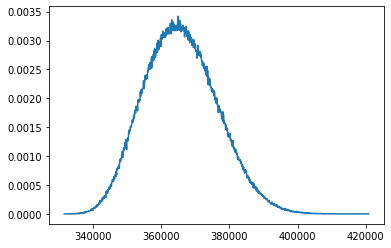

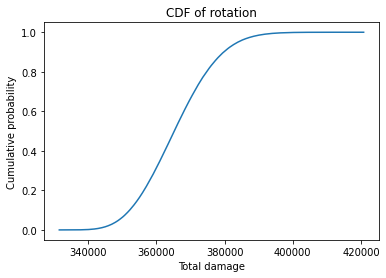

In [104]:
start_time = time.time()
sim = Simulator(stats, rb.build())
total_damage = sim.simulate()
end_time = time.time()

count, bins_count = np.histogram(total_damage, bins=1000)
pdf = count / sum(count)
plt.figure()
plt.plot(bins_count[1:], pdf, label="PDF")
cdf = np.cumsum(pdf)
plt.figure()
plt.plot(bins_count[1:], cdf, label="CDF")
plt.title('CDF of rotation')
plt.xlabel('Total damage')
plt.ylabel('Cumulative probability')
print('Average damage: ' + str(np.mean(total_damage)))
print('Average dps: ' + str(np.mean(total_damage/fight_time)))
print('Time taken: ' + str(end_time-start_time))